# SARS-CoV-2 Knowledge Graph 

Load packages

In [1]:
import numpy as np
import pandas as pd
import time
import re
import math
import random
import pickle
import seaborn as sns

import lazypredict
from lazypredict.Supervised import LazyRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_remaining_self_loops, negative_sampling
from torch_geometric.nn import VGAE, GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_path='data/'
exp_id='v0'
device_id='cpu' #'cpu' if CPU, device number if GPU
embedding_size=128
topk=300

Load preprocessed files

In [3]:
le=pickle.load(open(data_path+'LabelEncoder_'+exp_id+'.pkl', 'rb'))
edge_index=pickle.load(open(data_path+'edge_index_'+exp_id+'.pkl','rb'))
node_feature_np=pickle.load(open(data_path+'node_feature_'+exp_id+'.pkl','rb'))

In [4]:
# For tensor representing node
node_feature=torch.tensor(node_feature_np, dtype=torch.float)
input_ft = node_feature.size(1)
print("input_ft: ", input_ft)

input_ft:  400


In [5]:
# Normalized node_features - intend to see if this can help model perform better but not :( 
# scaler = MinMaxScaler()
# node_feature = scaler.fit_transform(node_feature)

In [6]:
edge=torch.tensor(edge_index[['node1', 'node2']].values, dtype=torch.long)

In [7]:
# edge_attr_dict maps edge type to the unique numeric identifier
edge_attr_dict={'gene-drug':0,'gene-gene':1,'bait-gene':2, 'phenotype-gene':3, 'phenotype-drug':4}
edge_index['type']=edge_index['type'].apply(lambda x: edge_attr_dict[x])

In [8]:
edge_index['type'].value_counts()

type
1    14242
4      410
3      325
2      281
0      189
Name: count, dtype: int64

In [9]:
edge_attr=torch.tensor(edge_index['type'].values,dtype=torch.long)

In [10]:
# Preparing a Data object for a graph, including node features, edge information (transposed and contiguous), and edge attributes
data = Data(x=node_feature,
            edge_index=edge.t().contiguous(),
            edge_attr=edge_attr
           )

## Batch

In [11]:
def train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1):
    """Splits the edges of a `torch_geometric.data.Data` object
            into positive and negative train/val/test edges, and adds attributes of
        `train_pos_edge_index`, `train_neg_adj_mask`, `val_pos_edge_index`,
        `val_neg_edge_index`, `test_pos_edge_index`, and `test_neg_edge_index`
        to :attr:`data`.

    Args:
        data (Data): The data object.
        val_ratio (float, optional): The ratio of positive validation
            edges. (default: :obj:`0.05`)
        test_ratio (float, optional): The ratio of positive test
            edges. (default: :obj:`0.1`)

    :rtype: :class:`torch_geometric.data.Data`
    """

    assert 'batch' not in data  # No batch-mode.

    num_nodes = data.num_nodes
    row, col = data.edge_index
    attr = data.edge_attr


    n_v = int(math.floor(val_ratio * row.size(0)))
    n_t = int(math.floor(test_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]
    attr=attr[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    data.val_pos_edge_attr = attr[:n_v]
    
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)
    data.test_post_edge_attr = attr[n_v:n_v + n_t]

    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_attr = attr[n_v+n_t:]

    # Negative edges.
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0

    neg_row, neg_col = neg_adj_mask.nonzero().t()
    perm = random.sample(range(neg_row.size(0)),
                         min(n_v + n_t, neg_row.size(0)))
    perm = torch.tensor(perm)
    perm = perm.to(torch.long)
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    row, col = neg_row[:n_v], neg_col[:n_v]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
    data.test_neg_edge_index = torch.stack([row, col], dim=0)

    return data

In [12]:
device=torch.device(device_id)

In [13]:
data_split=train_test_split_edges(data)
x,train_pos_edge_index,train_pos_edge_attr = data_split.x.to(device), data_split.train_pos_edge_index.to(device), data_split.train_pos_edge_attr.to(device)
train_pos_edge_index, train_pos_edge_attr=add_remaining_self_loops(train_pos_edge_index,train_pos_edge_attr)
x,train_pos_edge_index,train_pos_edge_attr = Variable(x),Variable(train_pos_edge_index),Variable(train_pos_edge_attr)

### Learning models

#### GCN model

In [14]:
class Encoder_GCN(nn.Module):
    def __init__(self, in_channels, out_channels, isClassificationTask=False):
        super(Encoder_GCN, self).__init__()
        self.isClassificationTask=isClassificationTask
        self._gene_drug=  GCNConv(in_channels, 2*out_channels)
        self._gene_gene = GCNConv(in_channels, 2*out_channels)
        self._bait_gene = GCNConv(in_channels, 2*out_channels)
        self._gene_phenotype = GCNConv(in_channels, 2*out_channels)
        self._drug_phenotype = GCNConv(in_channels, 2*out_channels)

        self.bn = nn.BatchNorm1d(5*2*out_channels)
        #variational encoder
        self._mu = GCNConv(5*2*out_channels, out_channels)
        self._logvar = GCNConv(5*2*out_channels, out_channels)

    def forward(self,x,edge_index,edge_attr):
        
        x = F.dropout(x, training=self.training)

        # Extract subgraphs based on edge attributes
        edge_indices = []
        for attr_value in range(5):
            indices = (edge_attr == attr_value).nonzero().reshape(1, -1)[0]
            edge_indices.append(edge_index[:, indices])
        
        edge_index_gene_drug, edge_index_gene_gene, edge_index_bait_gene, edge_index_gene_phenotype, edge_index_drug_phenotype = edge_indices

        # gcn -> relu -> dropout
        x_gene_drug = F.dropout(F.relu(self._gene_drug(x, edge_index_gene_drug)), p=0.5, training=self.training)
        x_gene_gene = F.dropout(F.relu(self._gene_gene(x, edge_index_gene_gene)), p=0.5, training=self.training)
        x_bait_gene = F.dropout(F.relu(self._bait_gene(x, edge_index_bait_gene)), p=0.1, training=self.training)
        x_gene_phenotype = F.dropout(F.relu(self._gene_phenotype(x, edge_index_gene_phenotype)), training=self.training)
        x_drug_phenotype = F.dropout(F.relu(self._drug_phenotype(x, edge_index_drug_phenotype)), training=self.training)

        # concat
        batch_input = torch.cat([x_gene_drug, x_gene_gene, x_bait_gene, x_gene_phenotype, x_drug_phenotype], dim=1)

        # batch norm
        x = self.bn(batch_input)

        return self._mu(x, edge_index), self._logvar(x, edge_index)

In [15]:
class Decoder_GCN(nn.Module):
    def __init__(self, input_features, output_features):
        super(Decoder_GCN, self).__init__()
        self.fc1 = nn.Linear(input_features, 256)
        self.fc2 = nn.Linear(256, output_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [16]:
model = VGAE(Encoder_GCN(node_feature.shape[1], embedding_size)).to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

VGAE(
  (encoder): Encoder_GCN(
    (_gene_drug): GCNConv(400, 256)
    (_gene_gene): GCNConv(400, 256)
    (_bait_gene): GCNConv(400, 256)
    (_gene_phenotype): GCNConv(400, 256)
    (_drug_phenotype): GCNConv(400, 256)
    (bn): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_mu): GCNConv(1280, 128)
    (_logvar): GCNConv(1280, 128)
  )
  (decoder): InnerProductDecoder()
)


In [17]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index, train_pos_edge_attr)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    print(loss.item())
    
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z=model.encode(x, train_pos_edge_index,train_pos_edge_attr)
    return model.test(z, pos_edge_index, neg_edge_index)

In [18]:
#DRKG's accuracy for comparison
model.test(x,data_split.test_pos_edge_index, data_split.test_neg_edge_index )

(0.8427287896990524, 0.7901016351203227)

In [19]:
for epoch in range(1, 10):
    train()
    auc, ap = test(data_split.test_pos_edge_index, data_split.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

39.03314208984375
Epoch: 001, AUC: 0.5637, AP: 0.5342
8827.9775390625
Epoch: 002, AUC: 0.5767, AP: 0.5418
3869.960205078125
Epoch: 003, AUC: 0.5798, AP: 0.5437
2688.222412109375
Epoch: 004, AUC: 0.5870, AP: 0.5480
809.1705322265625
Epoch: 005, AUC: 0.5982, AP: 0.5548
1728.4910888671875
Epoch: 006, AUC: 0.6160, AP: 0.5660


1216.0430908203125
Epoch: 007, AUC: 0.6363, AP: 0.5792
1485.9560546875
Epoch: 008, AUC: 0.6513, AP: 0.5896
619.4754638671875
Epoch: 009, AUC: 0.6673, AP: 0.6010


In [20]:
# Customize Autoencoder that can take Encoder_GCN as input
class CustomizedGCN_Autoencoder(nn.Module):
    def __init__(self, encoder, input_features=400, hidden_size=256, output_features=400):
        super(CustomizedGCN_Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = Decoder_GCN(hidden_size, input_features)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x, edge_index, edge_attr):
        mu, logvar = self.encoder(x, edge_index, edge_attr)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar


In [21]:
other_model = CustomizedGCN_Autoencoder(Encoder_GCN(node_feature.shape[1], embedding_size)).to(device)
optimizer=torch.optim.Adam(other_model.parameters(), lr=0.01)
print(other_model)

CustomizedGCN_Autoencoder(
  (encoder): Encoder_GCN(
    (_gene_drug): GCNConv(400, 256)
    (_gene_gene): GCNConv(400, 256)
    (_bait_gene): GCNConv(400, 256)
    (_gene_phenotype): GCNConv(400, 256)
    (_drug_phenotype): GCNConv(400, 256)
    (bn): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_mu): GCNConv(1280, 128)
    (_logvar): GCNConv(1280, 128)
  )
  (decoder): Decoder_GCN(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=400, bias=True)
  )
)


In [22]:
for epoch in range(1, 10):
    train()
    auc, ap = test(data_split.test_pos_edge_index, data_split.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

777.31494140625


Epoch: 001, AUC: 0.6846, AP: 0.6138
632.0750732421875
Epoch: 002, AUC: 0.7014, AP: 0.6269
990.2532958984375
Epoch: 003, AUC: 0.7131, AP: 0.6363
2105.673828125
Epoch: 004, AUC: 0.7248, AP: 0.6461
1330.46142578125
Epoch: 005, AUC: 0.7365, AP: 0.6563
1202.1494140625
Epoch: 006, AUC: 0.7450, AP: 0.6638
548.5679321289062
Epoch: 007, AUC: 0.7514, AP: 0.6696
1197.609130859375
Epoch: 008, AUC: 0.7577, AP: 0.6754
722.9336547851562
Epoch: 009, AUC: 0.7617, AP: 0.6791


Node embedding

In [23]:
model.eval()
z=model.encode(x, data.edge_index.to(device), data.edge_attr.to(device))
z_np = z.squeeze().detach().cpu().numpy()

Save the new embedding 

In [24]:
pickle.dump(z_np, open(data_path+'node_embedding_'+exp_id+'.pkl', 'wb'))

Save the torch model

In [25]:
torch.save(model.state_dict(), data_path+'VAE_encoders_'+exp_id+'.pkl')

In [26]:
model.load_state_dict(torch.load(data_path+'VAE_encoders_'+exp_id+'.pkl'))
model.eval()

VGAE(
  (encoder): Encoder_GCN(
    (_gene_drug): GCNConv(400, 256)
    (_gene_gene): GCNConv(400, 256)
    (_bait_gene): GCNConv(400, 256)
    (_gene_phenotype): GCNConv(400, 256)
    (_drug_phenotype): GCNConv(400, 256)
    (bn): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_mu): GCNConv(1280, 128)
    (_logvar): GCNConv(1280, 128)
  )
  (decoder): InnerProductDecoder()
)

## Ranking models

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [28]:
topk=300
num_epochs=30
types=np.array([item.split('_')[0] for item in le.classes_ ])

Load drugs under clinical trial

In [29]:
#label
trials=pd.read_excel(data_path+'literature-mining/All_trails_5_24.xlsx',header=1,index_col=0)
trials_drug=set([drug.strip().upper() for lst in trials.loc[trials['study_category'].apply(lambda x: 'drug' in x.lower()),'intervention'].apply(lambda x: re.split(r'[+|/|,]',x.replace(' vs. ', '/').replace(' vs ', '/').replace(' or ', '/').replace(' with and without ', '/').replace(' /wo ', '/').replace(' /w ', '/').replace(' and ', '/').replace(' - ', '/').replace(' (', '/').replace(') ', '/'))).values for drug in lst])
drug_labels=[1 if drug.split('_')[1] in trials_drug else 0 for drug in le.classes_[types=='drug'] ]


#### BPR (Bayesian Personalized Ranking) loss NN

In [30]:
seed=70
indices = np.arange(len(drug_labels))
X_train, X_test, y_train, y_test,indices_train,indices_test=train_test_split(z_np[types=='drug'],drug_labels,indices, test_size=0.5,random_state=seed,)


In [31]:
#Variable wrapping for torch.tensor
_X_train, _y_train=Variable(torch.tensor(X_train,dtype=torch.float).to(device)), Variable(torch.tensor(y_train,dtype=torch.float).to(device))
_X_test, _y_test=Variable(torch.tensor(X_test,dtype=torch.float).to(device)), Variable(torch.tensor(y_test,dtype=torch.float).to(device))

In [32]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        self.fc1=nn.Linear(128,128)
        self.fc2=nn.Linear(128,1)
        self.bn=nn.BatchNorm1d(128)
    def forward(self, x):
        residual = x
        out = F.dropout(F.relu(self.fc1(x)))
        out = self.bn(out)
        out += residual
        return self.fc2(x)        

BPR Loss Function

In [33]:
from torch.utils.data import BatchSampler, WeightedRandomSampler
class BPRLoss(nn.Module):
    def __init__(self, num_neg_samples):
        super(BPRLoss, self).__init__()
        self.num_neg_samples=num_neg_samples
    
    def forward(self, output, label):
        positive_output=output[label==1]
        negative_output=output[label!=1]

        log_prob = F.logsigmoid(positive_output.view(-1,1) - negative_output).mean()

        return -log_prob

In [34]:
classifier=Classifier().to(device)
optimizer=torch.optim.Adam(classifier.parameters())
criterion=BPRLoss(num_neg_samples=15)

In [35]:
best_auprc=0
classifier_loss = []
for epoch in range(num_epochs):
    classifier.train()
    optimizer.zero_grad()
    out = classifier(_X_train)
    loss=criterion(out.squeeze(), _y_train)
    loss.backward()
    optimizer.step()   
    print('training loss',loss.item())

    classifier.eval()
    test_loss = criterion(classifier(_X_test).squeeze(), _y_test).item()
    classifier_loss.append(test_loss)
    print('test loss', test_loss)
    prob=torch.sigmoid(classifier(_X_test)).cpu().detach().numpy().squeeze()
    auprc=metrics.average_precision_score(y_test,prob)
    if auprc>best_auprc:
        best_auproc=auprc
        torch.save(classifier, data_path+'nn_clf-temp.pt')

training loss 3.1959381103515625
test loss 2.430955410003662
training loss 2.387193441390991
test loss 1.5217387676239014
training loss 1.6508269309997559
test loss 0.8644008040428162
training loss 1.1305713653564453
test loss 0.6420910954475403
training loss 0.8530521988868713
test loss 0.6816923022270203
training loss 0.6983205080032349
test loss 0.7946802377700806
training loss 0.6218321323394775
test loss 0.9206209182739258
training loss 0.5933507680892944
test loss 1.041693925857544
training loss 0.5893212556838989
test loss 1.1521250009536743
training loss 0.596060574054718
test loss 1.2502548694610596
training loss 0.6067626476287842
test loss 1.33597731590271
training loss 0.6181330680847168
test loss 1.409796118736267
training loss 0.6285768151283264
test loss 1.4724453687667847
training loss 0.6373342275619507
test loss 1.524724006652832
training loss 0.6440693140029907
test loss 1.5674242973327637
training loss 0.6486665606498718
test loss 1.6013011932373047
training loss 0.

In [36]:
classifier.load_state_dict(torch.load(data_path+'nn_clf-temp.pt').state_dict())

<All keys matched successfully>

In [37]:
#Compute AUC
classifier.eval()

prob=torch.sigmoid(classifier(_X_test)).cpu().detach().numpy().squeeze()
print("AUROC", metrics.roc_auc_score(y_test,prob))
print("AUPRC", metrics.average_precision_score(y_test,prob))

AUROC 0.734375
AUPRC 0.691693722943723


### Other models for comparison

#### Long Short-Term Memory (LSTM) - a type of RNN

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=3, num_layers=3, output_size=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
#         print("LSTM Output Shape:", out.shape)
        out = self.sigmoid(self.fc(out))
        return out


In [39]:
lstm=LSTM().to(device)
optimizer=torch.optim.Adam(lstm.parameters())
criterion=BPRLoss(num_neg_samples=15)

best_auprc=0
lstm_loss = []
for epoch in range(30):
    lstm.train()
    optimizer.zero_grad()
    out = lstm(_X_train)
    loss=criterion(out.squeeze(), _y_train)
    loss.backward()
    optimizer.step()   
    print('training loss',loss.item())

    lstm.eval()
    test_loss = criterion(lstm(_X_test).squeeze(), _y_test).item()
    lstm_loss.append(test_loss)
    print('test loss', test_loss)
    prob=torch.sigmoid(lstm(_X_test)).cpu().detach().numpy().squeeze()
    auprc=metrics.average_precision_score(y_test,prob)
    if auprc>best_auprc:
        best_auproc=auprc
        torch.save(lstm, data_path+'nn_lstm-temp.pt')

training loss 0.6933202147483826
test loss 0.6931403279304504
training loss 0.693313717842102
test loss 0.6931408643722534
training loss 0.6933079361915588
test loss 0.6931414604187012
training loss 0.6933027505874634
test loss 0.6931421160697937
training loss 0.693297803401947
test loss 0.6931427717208862
training loss 0.6932929754257202
test loss 0.6931434273719788
training loss 0.6932883262634277
test loss 0.6931440234184265
training loss 0.6932839751243591
test loss 0.693144679069519
training loss 0.6932798624038696
test loss 0.693145215511322
training loss 0.693276047706604
test loss 0.6931458115577698
training loss 0.6932724118232727
test loss 0.6931462287902832
training loss 0.6932691931724548
test loss 0.6931467056274414
training loss 0.6932660341262817
test loss 0.6931470632553101
training loss 0.693263053894043
test loss 0.6931474208831787
training loss 0.6932600736618042
test loss 0.6931477189064026
training loss 0.693257212638855
test loss 0.6931479573249817
training loss 0

In [40]:
lstm.load_state_dict(torch.load(data_path+'nn_lstm-temp.pt').state_dict())

<All keys matched successfully>

In [41]:
#Compute AUC
lstm.eval()

prob=torch.sigmoid(lstm(_X_test)).cpu().detach().numpy().squeeze()
print("AUROC", metrics.roc_auc_score(y_test,prob))
print("AUPRC", metrics.average_precision_score(y_test,prob))

AUROC 0.5546875
AUPRC 0.49431818181818177


#### multi-layer perceptron (MLP) 

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size=128, hidden_size=3, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
mlp=MLP().to(device)
optimizer=torch.optim.Adam(mlp.parameters())
criterion=BPRLoss(num_neg_samples=15)

best_auprc=0
mlp_loss = []
for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    out = mlp(_X_train)
    loss=criterion(out.squeeze(), _y_train)
    loss.backward()
    optimizer.step()   
    print('training loss',loss.item())

    mlp.eval()
    test_loss = criterion(mlp(_X_test).squeeze(), _y_test).item()
    mlp_loss.append(test_loss)
    print('test loss', test_loss)
    prob=torch.sigmoid(mlp(_X_test)).cpu().detach().numpy().squeeze()
    auprc=metrics.average_precision_score(y_test,prob)
    if auprc>best_auprc:
        best_auproc=auprc
        torch.save(mlp, data_path+'nn_mlp-temp.pt')

training loss 1.2237253189086914
test loss 1.196097731590271
training loss 1.113087773323059
test loss 1.070094108581543
training loss 1.0091352462768555
test loss 0.955367386341095
training loss 0.9129294157028198
test loss 0.8544511795043945
training loss 0.8248276114463806
test loss 0.7676422595977783
training loss 0.745206892490387
test loss 0.6886794567108154
training loss 0.6947768330574036
test loss 0.6904357671737671
training loss 0.683192253112793
test loss 0.6928696036338806
training loss 0.6865628957748413
test loss 0.6948503255844116
training loss 0.6826850771903992
test loss 0.6924518942832947
training loss 0.674152672290802
test loss 0.6897172927856445
training loss 0.6712692975997925
test loss 0.6969181299209595
training loss 0.6706118583679199
test loss 0.689705491065979
training loss 0.6658141016960144
test loss 0.6823589205741882
training loss 0.6555891633033752
test loss 0.683233380317688
training loss 0.6437762379646301
test loss 0.6801101565361023
training loss 0.6

In [44]:
mlp.load_state_dict(torch.load(data_path+'nn_mlp-temp.pt').state_dict())

<All keys matched successfully>

In [45]:
#Compute AUC
mlp.eval()

prob=torch.sigmoid(mlp(_X_test)).cpu().detach().numpy().squeeze()
print("AUROC", metrics.roc_auc_score(y_test,prob))
print("AUPRC", metrics.average_precision_score(y_test,prob))

AUROC 0.5703125
AUPRC 0.4085526315789474


#### Transformer-based model 

In [46]:
class Transformer(nn.Module):
    def __init__(self, input_size=128, hidden_size=3, output_size=1, num_heads=2, num_layers=2):
        super(Transformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.transformer(x)
        
        # Reshape the output to 2D tensor before passing it through the fully connected layer
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        return out


In [47]:
transformer=Transformer().to(device)
optimizer=torch.optim.Adam(transformer.parameters())
criterion=BPRLoss(num_neg_samples=15)

best_auprc=0
transformer_loss=[]
for epoch in range(num_epochs):
    transformer.train()
    optimizer.zero_grad()
    out = transformer(_X_train)
    loss=criterion(out.squeeze(), _y_train)
    loss.backward()
    optimizer.step()   
    print('training loss',loss.item())

    transformer.eval()
    test_loss = criterion(transformer(_X_test).squeeze(), _y_test).item()
    transformer_loss.append(test_loss)
    print('test loss', test_loss)
    prob=torch.sigmoid(transformer(_X_test)).cpu().detach().numpy().squeeze()
    auprc=metrics.average_precision_score(y_test,prob)
    if auprc>best_auprc:
        best_auproc=auprc
        torch.save(transformer, data_path+'nn_transformer-temp.pt')

training loss 0.712260365486145
test loss 0.7022756338119507
training loss 0.7633072733879089
test loss 0.853826642036438
training loss 0.3327845335006714
test loss 0.8735266327857971
training loss 0.4025035500526428
test loss 0.8922548294067383
training loss 0.5770223140716553
test loss 0.9067201614379883
training loss 0.4350810647010803
test loss 0.9518563151359558
training loss 0.493336021900177
test loss 0.9744397401809692
training loss 0.5102469325065613
test loss 0.9715859889984131
training loss 0.5768285989761353
test loss 0.9272536039352417
training loss 0.4861105680465698
test loss 0.8881615400314331
training loss 0.4409347176551819
test loss 0.90054851770401
training loss 0.48743224143981934
test loss 0.9456788301467896
training loss 0.3760095238685608
test loss 0.9804260730743408
training loss 0.41346630454063416


test loss 0.9787229299545288
training loss 0.44811421632766724
test loss 0.9913187026977539
training loss 0.43853774666786194
test loss 1.0181821584701538
training loss 0.327368825674057
test loss 1.0835387706756592
training loss 0.38919132947921753
test loss 1.1305032968521118
training loss 0.3093346953392029
test loss 1.0912424325942993
training loss 0.49240413308143616
test loss 1.0333428382873535
training loss 0.28391584753990173
test loss 1.0188984870910645
training loss 0.3034684360027313
test loss 1.0103707313537598
training loss 0.20030193030834198
test loss 1.0060796737670898
training loss 0.23263053596019745
test loss 0.9788365960121155
training loss 0.3084690570831299
test loss 0.9979156255722046
training loss 0.22445088624954224
test loss 0.9833378791809082
training loss 0.3261670172214508
test loss 0.9067197442054749
training loss 0.32904064655303955
test loss 0.8893395066261292
training loss 0.18895520269870758
test loss 0.8963222503662109
training loss 0.5698607563972473

In [48]:
transformer.load_state_dict(torch.load(data_path+'nn_transformer-temp.pt').state_dict())

<All keys matched successfully>

In [49]:
#Compute AUC
transformer.eval()

prob=torch.sigmoid(transformer(_X_test)).cpu().detach().numpy().squeeze()
print("AUROC", metrics.roc_auc_score(y_test,prob))
print("AUPRC", metrics.average_precision_score(y_test,prob))

AUROC 0.6484375
AUPRC 0.4460053835053835


#### KNN model

AUROC FOR 3 NEIGHBORS: 0.6953125
AUPRC FOR 3 NEIGHBORS: 0.513157894736842
AUROC FOR 4 NEIGHBORS: 0.7109375
AUPRC FOR 4 NEIGHBORS: 0.6211309523809524
AUROC FOR 5 NEIGHBORS: 0.64453125
AUPRC FOR 5 NEIGHBORS: 0.44627192982456143
AUROC FOR 6 NEIGHBORS: 0.703125
AUPRC FOR 6 NEIGHBORS: 0.49144345238095233
AUROC FOR 7 NEIGHBORS: 0.73046875
AUPRC FOR 7 NEIGHBORS: 0.6510416666666666
AUROC FOR 8 NEIGHBORS: 0.640625
AUPRC FOR 8 NEIGHBORS: 0.41849415204678364
AUROC FOR 9 NEIGHBORS: 0.6640625
AUPRC FOR 9 NEIGHBORS: 0.45560897435897435
AUROC FOR 10 NEIGHBORS: 0.70703125
AUPRC FOR 10 NEIGHBORS: 0.6376633986928104
AUROC FOR 11 NEIGHBORS: 0.7109375
AUPRC FOR 11 NEIGHBORS: 0.5451388888888888
AUROC FOR 12 NEIGHBORS: 0.67578125
AUPRC FOR 12 NEIGHBORS: 0.491025641025641
AUROC FOR 13 NEIGHBORS: 0.68359375
AUPRC FOR 13 NEIGHBORS: 0.5451388888888888
AUROC FOR 14 NEIGHBORS: 0.671875
AUPRC FOR 14 NEIGHBORS: 0.4888888888888889
AUROC FOR 15 NEIGHBORS: 0.69140625
AUPRC FOR 15 NEIGHBORS: 0.4888888888888889


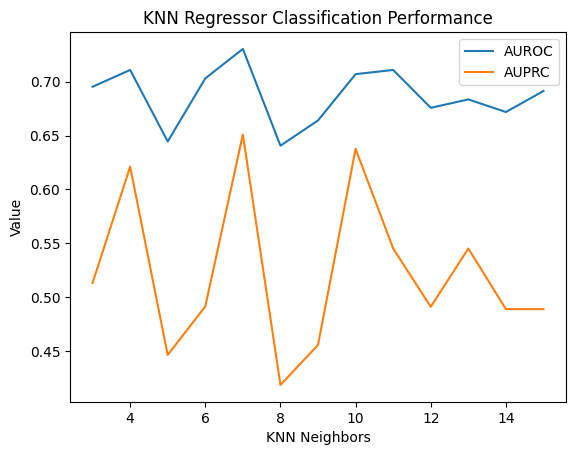

In [50]:
neighbor= []
knn_auroc = []
knn_auprc = []
for num_neighs in range(3,16):
    neighbor.append(num_neighs)
    knn = KNeighborsRegressor(n_neighbors=num_neighs)
    knn.fit(X_train, y_train)

    prob = knn.predict(X_test)

    auroc = metrics.roc_auc_score(y_test,prob)
    knn_auroc.append(auroc)
    auprc = metrics.average_precision_score(y_test,prob)
    knn_auprc.append(auprc)

    print("AUROC FOR {} NEIGHBORS: {}".format(num_neighs, auroc))
    print("AUPRC FOR {} NEIGHBORS: {}".format(num_neighs, auprc))

plt.plot(neighbor, knn_auroc, label="AUROC")
plt.plot(neighbor, knn_auprc, label="AUPRC")
plt.title("KNN Regressor Classification Performance")
plt.xlabel("KNN Neighbors")
plt.ylabel("Value")
plt.legend()
plt.show()

#### SVM model

In [51]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
clf.fit(X_train, y_train)
prob = clf.predict(X_test)
print("AUROC", metrics.roc_auc_score(y_test, prob))
print("AUPRC", metrics.average_precision_score(y_test, prob))

AUROC 0.65625
AUPRC 0.4244791666666667


### Get drug rankings from Classifier model

Sort the result form Classsifer model

In [52]:
z_np[types=='drug']
res_tensor = -classifier(torch.from_numpy(z_np[types=='drug']))
sorted_picks = np.argsort(res_tensor.squeeze().detach().numpy())
sorted_picks

array([15, 40, 29, 45, 22, 19, 24,  6, 17, 27, 10,  7, 37, 33, 16, 41,  8,
       25, 36, 18, 38, 39, 34, 12, 46, 42, 11, 14,  5, 31, 30, 26, 13, 28,
       43, 35, 21,  3, 32,  2, 44,  1,  9, 20, 23,  4,  0], dtype=int64)

Save the high-ranked drugs into csv file

In [53]:
topk_drugs=pd.DataFrame([(rank, drug.split('_')[1]) for rank,drug in enumerate(le.inverse_transform((types=='drug').nonzero()[0][sorted_picks])[:topk+1])], columns=['rank', 'drug'])
topk_drugs['under_trials']=topk_drugs['drug'].isin(trials_drug).astype(int)
topk_drugs['is_used_in_training']=topk_drugs['drug'].isin(np.array([drug.split('_')[1] for drug in le.classes_[types=='drug']])[indices_train]).astype(int)
topk_drugs.to_csv('top300_drugs.csv')

PermissionError: [Errno 13] Permission denied: 'top300_drugs.csv'

#### Baseline Models

In [ ]:
# Defines and builds the lazyclassifier
lg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = lg.fit(X_train, X_train, y_train, y_train)
models_test,predictions_test = lg.fit(X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.70it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score 0.521739
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.65it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score 0.521739
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [ ]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,77870562205638276405604120894344889842759471828...,-3751945269908026053500571714834598034699849942...,967581100705299106194527682035712.00,0.01
KernelRidge,1.26,-0.25,0.56,0.00
LassoLars,1.21,-0.00,0.50,0.00
Lasso,1.21,-0.00,0.50,0.00
ElasticNet,1.21,-0.00,0.50,0.00
HistGradientBoostingRegressor,1.21,0.00,0.50,0.21
LGBMRegressor,1.21,0.00,0.50,0.03
DummyRegressor,1.21,0.00,0.50,0.00
KNeighborsRegressor,1.16,0.24,0.44,0.00


In [ ]:
# Performance table of the test set (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,46896984042069344031614286464025195919303559967...,-2140949271485774353409786754746549620876947803...,21812072454826858793905583801671614464.00,0.01
LinearRegression,1.77,-2.52,0.88,0.00
TransformedTargetRegressor,1.77,-2.52,0.88,0.00
ExtraTreeRegressor,1.53,-1.44,0.74,0.00
AdaBoostRegressor,1.45,-1.06,0.68,0.02
LinearSVR,1.39,-0.80,0.63,0.01
HuberRegressor,1.39,-0.78,0.63,0.01
DecisionTreeRegressor,1.37,-0.69,0.61,0.00
XGBRegressor,1.36,-0.66,0.61,0.13


[(0.0, 1.0)]

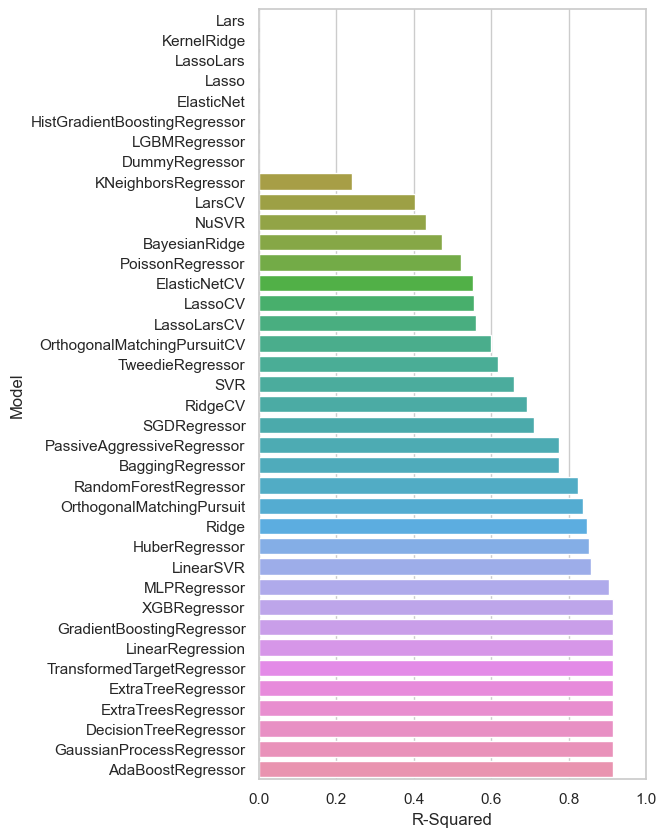

In [ ]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

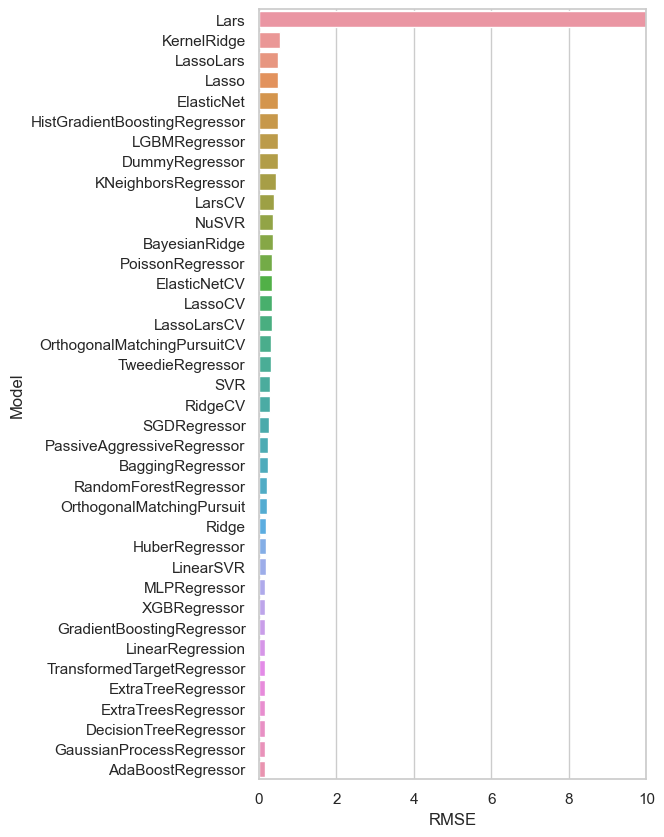

In [ ]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

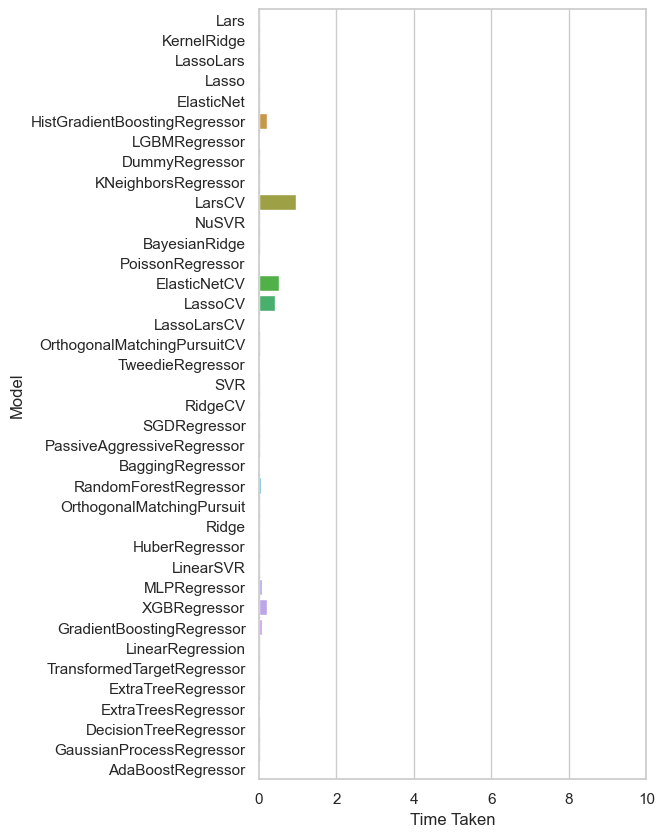

In [ ]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))